In [1]:
import time
import torch
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

from zse.collections import *
from zse.utilities import *

from ase.io import read, write
from matplotlib import cm

from collections import Counter

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64


from sklearn.cluster import DBSCAN


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
def get_fw_data(file,code):
    
    # file is the file we want to read from
    # code is the IZA framework code you want data on
    
    file = open(file,'r')
    data = file.readlines()
    file.close()
    
    for i,line in enumerate(data):
        fields = line.split()
        if fields[0] == code:
            start = i
            break
    
    # go through fw chunk and get data
    
    t_sites = {}
    o_sites = {}
    for i,line in enumerate(data[start+1:]):
        line = line.rstrip(' \n')

        # get the t site rings
        
        if 'T' in line and ':' in line:
            fields = line.split(':')
            t_sites[fields[0]]=fields[1]                
        
        # get the o site rings
        
        if 'O' in line and ':' in line:
            fields = line.split(':')
            o_sites[fields[0]]=fields[1]        
        
        fields = line.split()
        if fields[0] == 'Framework':
            end = i+start-1
            break

    return(t_sites,o_sites)    

In [3]:
fws = get_all_fws()
file = '../Data/sastre_rings.txt'
tdata= []
for f in fws:
    tsites,osites = get_fw_data(file,f)
    for t in tsites:
        ring_list = [int(x) for x in tsites[t].split('_')]
        temp = [0]*19
        for r in ring_list:
            temp[r]+=1
        temp.insert(0,t)
        temp.insert(0,f)
        tdata.append(temp)

In [4]:
df = pd.DataFrame(tdata, columns = ['Framework', 'Tsite','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'])
print(df)

     Framework Tsite  0  1  2  3  4  5  6  7  ...  9  10  11  12  13  14  15  \
0          ABW    T1  0  0  0  0  2  0  3  0  ...  0   0   0   0   0   0   0   
1          ACO    T1  0  0  0  0  3  0  0  0  ...  0   0   0   0   0   0   0   
2          AEI    T1  0  0  0  0  3  0  1  0  ...  0   0   0   0   0   0   0   
3          AEI    T2  0  0  0  0  3  0  1  0  ...  0   0   0   0   0   0   0   
4          AEI    T3  0  0  0  0  3  0  1  0  ...  0   0   0   0   0   0   0   
...        ...   ... .. .. .. .. .. .. .. ..  ... ..  ..  ..  ..  ..  ..  ..   
1455       SYT    T2  0  0  0  0  3  0  2  0  ...  0   0   0   0   0   0   0   
1456       SYT    T3  0  0  0  0  3  0  2  0  ...  0   0   0   0   0   0   0   
1457       SYT    T4  0  0  0  0  3  0  0  0  ...  0   0   0   0   0   0   0   
1458       SYT    T5  0  0  0  0  3  0  2  0  ...  0   0   0   0   0   0   0   
1459       SYT    T6  0  0  0  0  3  0  0  0  ...  0   0   0   0   0   0   0   

      16  17  18  
0      0   0   0  
1

In [5]:
iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
density = iza_values['Density (T sites/ 1000 Å^3)'].values



In [6]:
print(density)

[17.6 16.5 15.1 19.2 20.1 18.2 16.9 16.9 17.4 19.2 15.2 14.6 15.1 15.7
 15.1 14.1 19.2 19.2 17.7 18.  15.8 19.1 17.8 18.8 16.1 17.1 18.9 16.5
 15.8 18.2 16.9 19.  15.3 15.1 18.7 18.3 16.1 12.9 14.6 18.3 18.7 16.9
 18.8 18.1 16.8 19.  16.9 15.1 19.9 11.1 15.7 16.2 16.2 20.6 17.5 17.9
 14.9 17.7 17.  17.1 16.  16.3 17.9 13.3 16.8 17.7 16.1 17.7 18.  15.4
  nan 17.1  nan 17.3 14.5 17.2 17.1 13.3 17.6 17.1 16.4 17.1 15.1 17.7
 19.  17.5 17.3 17.2 12.1 12.1 15.8 17.6 18.5 17.5 15.3 11.8 11.1 15.
 15.7 16.6 17.4 16.  17.4 12.8 10.5 17.7 15.6 14.8 15.  16.6 18.8 20.5
 16.4 18.5 17.9 12.3 14.3 18.4 15.  18.  15.9 17.6 19.2 16.9 16.8 14.2
 16.9 18.5 16.7 17.  17.6 16.7 14.7 17.4 17.9 16.4 18.4 17.4 17.6 17.
 17.  19.7 17.1 16.4 17.8 20.7 17.2 18.2 18.2 21.  16.1 15.9 16.1 16.2
 16.4 17.6 15.9 13.5 18.8 12.7 16.1 17.5 17.7 13.3 17.1 19.5 15.9 18.8
 18.2 16.4 18.2 17.6 15.5 20.7  nan  nan 15.  15.6 17.1 17.  14.5 19.1
 17.9 16.8 17.2 16.1 18.1 19.2  7.6 19.  14.2 14.9 16.4 14.6 13.7 16.1
 13.7 13

In [7]:
def KMeans(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

tensor([[ 0.8105, -0.1545],
        [ 1.7086,  0.5220],
        [ 0.6616,  0.6702],
        ...,
        [ 1.4767,  0.5801],
        [-0.1310,  1.3091],
        [ 0.1197,  0.1446]], dtype=torch.float64)


[pyKeOps] Initializing build folder for dtype=float64 and lang=torch in /Users/cameronharristaylor/.cache/pykeops-1.5-cpython-38 ... 

FileNotFoundError: [Errno 2] No such file or directory: 'cmake'

In [ ]:
'''data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)'''

In [14]:
#try to get 

def numofrings(file,code):
    #might already be a function called counter so come up with very unique names otherwsie function overrides it -- isseue with kernel resets
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: number of each rings inside'''
    
    #call function to get data
    tsites, osites = get_fw_data(file,code)
    
    for t in tsites:
        #print('check 1')
        #resets dictionary each tsite
        tsite_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
        #ways to make dictionary without knowing what it is 
        
        #make into vector not dictionary 
        
        #restarts j to 1 to check for ring size
        j = 1
        #go through all of the one tsite
        for i in range(0,len(tsites[t])-2,2):
            #print('check 2')
            #set yes to true
            print('i is',i)
            yes = True
            while yes:
                #print('check 3')
                #print(tsites[t][i])
                #print(int(tsites[t][i]) == j)
                #print(tsite_dict[j])
                #number of rings matches dictionary component
                if int(tsites[t][i]) == j:
                    print('check 4')
                    tsite_dict[j] = tsite_dict[j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    
                    j = j + 1
                    print('j is',j)
        print(t,tsite_dict)
        

def nringsvector(code,file):
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: vector of number of rings for each tsite'''
    
    #get site data
    tsites, osites = get_fw_data(file,code)
    
    #create empty vector
    A = np.zeros([len(tsites),21])
    
    #coutner for which row of the matrix you are in
    k=0 
    
    #go through each tsite
    for t in tsites:
        #initialize accumulator 
        j=1
        
        #make list of number of rings
        tsites_list = tsites[t].split('_')
        #go through the string for each t list
        for i in range(0,len(tsites_list)):
            #make the while loop true each for loop
            yes = True
            while yes:
                if int(tsites_list[i]) == j:
                    A[k][j] = A[k][j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    j = j + 1
        #increase row
        k = k +1 
    return A

def assemblematrix(file):
    fws = get_all_fws()
    fws = fws[1:]
    B = nringsvector('ABW',file)
    for code in fws:
        C = nringsvector(code,file)
        B = np.append(B, C, axis=0)
    return B


In [15]:
A = assemblematrix('../Data/crum_rings.txt')

[pyKeOps] Initializing build folder for dtype=float64 and lang=torch in /Users/cameronharristaylor/.cache/pykeops-1.5-cpython-38 ... 

FileNotFoundError: [Errno 2] No such file or directory: 'cmake'

In [16]:
clustering = DBSCAN(eps=1,min_samples=5).fit(A)
cluster = clustering.labels_
print(len(cluster))

1460


In [17]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(cluster)

[ 0 -1  0  0  0  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2  3  0 -1 -1 -1 -1 -1
  1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1 -1 -1
  0  0 -1 -1  0 -1 -1 -1 -1 -1  0  0  0  0  4 -1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1 -1 -1  5 -1 -1 -1  6 -1 26  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  0  0  0  7 26 -1  7 -1 -1 -1 -1 -1  7  7 -1  7 -1 -1 -1
  7 -1 -1 -1 -1 -1  0  0 -1  0 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
  8 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1  7 -1 -1 -1  7  7
  7  7  7  7  0 -1 -1 10 -1  0 -1  7  7  7  7 -1 -1 -1 -1 -1  0  0 -1 -1
  5 -1  7  7 -1  5  7  5  7  5  0  0  0  0  7  7  7 -1  7  0  0  0 -1 -1
 -1 -1  7 10 -1  7 11 11 11 26  7 -1  0 -1  0  7  7 -1  5  7  7  7  5  7
 12 -1 -1 -1 -1 -1  0  7  2 -1 -1 -1 -1  0  0  2  3  0  7 -1  7  7  0  0
  0  0  0  0  0  0  2 -1 -1  0  0  5 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1
  7 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1  7  0

In [18]:
sorted_clusters = {-1:[],0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[],20:[],21:[],22:[],23:[],24:[],25:[],26:[],27:[],28:[],29:[],30:[],31:[],32:[],33:[]}

In [19]:
fws = get_all_fws()

start = 0
for code in fws:
    tsites, osites = get_fw_data(file,code)
    for t in tsites:
        name = code + t
        print(cluster[start])
        print(sorted_clusters[cluster[start]])
        sorted_clusters[cluster[start]].append(name)
        print(sorted_clusters)
        start = start + 1

0
[]
{-1: [], 0: ['ABWT1'], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: []}
-1
[]
{-1: ['ACOT1'], 0: ['ABWT1'], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: []}
0
['ABWT1']
{-1: ['ACOT1'], 0: ['ABWT1', 'AEIT1'], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: []}
0
['ABWT1', 'AEIT1']
{-1: ['ACOT1'], 0: ['ABWT1', 'AEIT1', 'AEIT2'], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8:

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4'], 0: ['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1'], 1: ['AELT1', 'AELT2', 'AFOT1'], 2: ['AFGT1'], 3: ['AFGT2'], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: []}
0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1']
{-1: ['ACOT1', 'AELT3'

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2'], 0: ['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1'], 1: ['AELT1', 'AELT2', 'AFOT1'], 2: ['AFGT1'], 3: ['AFGT2'], 4: ['ATTT2'], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: 

{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2'], 0: ['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2'], 1: ['AELT1', 'AELT2', 'AFOT1'], 2: ['AFGT1'], 3: ['AFGT2'], 4: ['ATTT2'], 5: ['BECT3'], 6: ['BOFT2'], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21:

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 

10
['DFOT4']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', '

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

7
['BRET1', 'BRET4', 'CDOT1', 'CDOT2', 'CDOT4', 'CFIT4', 'CSVT10', 'DACT2', 'DDRT2', 'DDRT3', 'DDRT4', 'DDRT5', 'DDRT6', 'DDRT7', 'DOHT1', 'DOHT2', 'DOHT3', 'DOHT4', 'EEIT3', 'EEIT4', 'EEIT7', 'EEIT9', 'EONT1', 'EONT2', 'EONT3', 'EONT5', 'EPIT3', 'ESVT1', 'ESVT6', 'EUOT1', 'EUOT2', 'EUOT5', 'EUOT6', 'EUOT7', 'EUOT9', 'EWST7', 'FERT1', 'FERT3', 'FERT4', 'HEUT1', 'HEUT5', 'IFTT11', 'IFWT8', 'IFWT10', 'IHWT6', 'IHWT7', 'IHWT8']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2'

15
[]
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4'

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', '

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

2
['AFGT1', 'EZTT1', 'FART3', 'GIUT2']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', '

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3', 'JBWT1', 'JSNT2', 'JSNT3', 'JSNT4', 'JSWT1', 'JSWT2', 'JSWT6', 'KFIT1', 'LEVT1', 'LEVT2', 'LIOT2', 'LIOT3', 'LOST1', 'LOST2', 'LTAT1', 'LTFT5', 'LTFT6']
{-1: ['

7
['BRET1', 'BRET4', 'CDOT1', 'CDOT2', 'CDOT4', 'CFIT4', 'CSVT10', 'DACT2', 'DDRT2', 'DDRT3', 'DDRT4', 'DDRT5', 'DDRT6', 'DDRT7', 'DOHT1', 'DOHT2', 'DOHT3', 'DOHT4', 'EEIT3', 'EEIT4', 'EEIT7', 'EEIT9', 'EONT1', 'EONT2', 'EONT3', 'EONT5', 'EPIT3', 'ESVT1', 'ESVT6', 'EUOT1', 'EUOT2', 'EUOT5', 'EUOT6', 'EUOT7', 'EUOT9', 'EWST7', 'FERT1', 'FERT3', 'FERT4', 'HEUT1', 'HEUT5', 'IFTT11', 'IFWT8', 'IFWT10', 'IHWT6', 'IHWT7', 'IHWT8', 'IMFT1', 'IMFT2', 'IMFT3', 'IMFT7', 'IMFT8', 'IMFT9', 'IMFT10', 'IMFT11', 'IMFT13', 'IMFT14', 'IMFT15', 'IMFT16', 'IMFT17', 'IMFT18', 'IMFT20', 'IMFT21', 'IMFT22', 'IRNT9', 'IRRT2', 'IRYT5', 'ISVT4', 'ITET2', 'ITET3', 'ITET4', 'ITHT9', 'ITRT8', 'ITTT2', 'IWST3', 'IWVT5', 'IWWT8', 'LTFT1', 'LTFT3', 'MAZT1', 'MELT1', 'MELT3']
{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

-1
['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EONT9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3', 'JBWT1', 'JSNT2', 'JSNT3', 'JSNT4', 'JSWT1', 'JSWT2', 'JSWT6', 'KFIT1', 'LEVT1', 'LEVT2', 'LIOT2', 'LIOT3', 'LOST1', 'LOST2', 'LTAT1', 'LTFT5', 'LTFT6', 'LTLT1'

7
['BRET1', 'BRET4', 'CDOT1', 'CDOT2', 'CDOT4', 'CFIT4', 'CSVT10', 'DACT2', 'DDRT2', 'DDRT3', 'DDRT4', 'DDRT5', 'DDRT6', 'DDRT7', 'DOHT1', 'DOHT2', 'DOHT3', 'DOHT4', 'EEIT3', 'EEIT4', 'EEIT7', 'EEIT9', 'EONT1', 'EONT2', 'EONT3', 'EONT5', 'EPIT3', 'ESVT1', 'ESVT6', 'EUOT1', 'EUOT2', 'EUOT5', 'EUOT6', 'EUOT7', 'EUOT9', 'EWST7', 'FERT1', 'FERT3', 'FERT4', 'HEUT1', 'HEUT5', 'IFTT11', 'IFWT8', 'IFWT10', 'IHWT6', 'IHWT7', 'IHWT8', 'IMFT1', 'IMFT2', 'IMFT3', 'IMFT7', 'IMFT8', 'IMFT9', 'IMFT10', 'IMFT11', 'IMFT13', 'IMFT14', 'IMFT15', 'IMFT16', 'IMFT17', 'IMFT18', 'IMFT20', 'IMFT21', 'IMFT22', 'IRNT9', 'IRRT2', 'IRYT5', 'ISVT4', 'ITET2', 'ITET3', 'ITET4', 'ITHT9', 'ITRT8', 'ITTT2', 'IWST3', 'IWVT5', 'IWWT8', 'LTFT1', 'LTFT3', 'MAZT1', 'MELT1', 'MELT3', 'MEPT1', 'MEPT2', 'MEPT3', 'MFIT2', 'MFIT3', 'MFIT4', 'MFIT6', 'MFIT8', 'MFIT10', 'MFIT11', 'MFIT12', 'MFST2', 'MFST5', 'MFST6', 'MFST8', 'MORT2', 'MTFT1', 'MTFT6', 'MTNT1', 'MTNT2', 'MTNT3', 'MTTT1', 'MTTT3', 'MTTT4', 'MTTT6', 'MTTT7', 'MTWT5',

{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EON

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3', 'JBWT1', 'JSNT2', 'JSNT3', 'JSNT4', 'JSWT1', 'JSWT2', 'JSWT6', 'KFIT1', 'LEVT1', 'LEVT2', 'LIOT2', 'LIOT3', 'LOST1', 'LOST2', 'LTAT1', 'LTFT5', 'LTFT6', 'LTLT1'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3', 'JBWT1', 'JSNT2', 'JSNT3', 'JSNT4', 'JSWT1', 'JSWT2', 'JSWT6', 'KFIT1', 'LEVT1', 'LEVT2', 'LIOT2', 'LIOT3', 'LOST1', 'LOST2', 'LTAT1', 'LTFT5', 'LTFT6', 'LTLT1'

0
['ABWT1', 'AEIT1', 'AEIT2', 'AEIT3', 'AFGT3', 'AFRT1', 'AFRT2', 'AFRT3', 'AFRT4', 'AFST1', 'AFST2', 'AFST3', 'AFTT1', 'AFTT2', 'AFTT3', 'AFVT1', 'AFVT2', 'AFVT3', 'AFXT1', 'AFXT2', 'AFYT2', 'APCT1', 'APCT2', 'ASTT1', 'ATST1', 'ATST2', 'ATST3', 'ATTT1', 'AVET1', 'AVET2', 'AVET3', 'AVET4', 'AVLT1', 'AVLT2', 'AVLT3', 'AVLT4', 'AWOT1', 'AWOT2', 'AWOT3', 'AWWT1', 'AWWT2', 'BOGT2', 'BPHT1', 'BPHT2', 'BPHT3', 'CGFT5', 'CGST1', 'CGST3', 'CHAT1', 'CLOT2', 'DFOT1', 'DFOT6', 'EABT1', 'EABT2', 'EMTT1', 'EMTT2', 'EMTT3', 'EMTT4', 'EONT6', 'EONT7', 'EONT8', 'ETRT2', 'ETRT4', 'EWST6', 'FART1', 'FART2', 'FAUT1', 'FRAT1', 'FRAT2', 'FRAT3', 'FRAT4', 'FRAT5', 'FRAT6', 'GIST1', 'GIUT1', 'GIUT5', 'GMET1', 'IFRT3', 'IFYT1', 'IFYT2', 'IFYT4', 'IRNT1', 'IRNT2', 'IRNT7', 'ITVT1', 'ITVT2', 'ITVT4', 'ITVT5', 'ITVT6', 'ITVT9', 'ITWT2', 'ITWT3', 'IWWT3', 'JBWT1', 'JSNT2', 'JSNT3', 'JSNT4', 'JSWT1', 'JSWT2', 'JSWT6', 'KFIT1', 'LEVT1', 'LEVT2', 'LIOT2', 'LIOT3', 'LOST1', 'LOST2', 'LTAT1', 'LTFT5', 'LTFT6', 'LTLT1'

In [44]:
print(sorted_clusters)

{-1: ['ACOT1', 'AELT3', 'AENT1', 'AENT2', 'AENT3', 'AETT1', 'AETT2', 'AETT3', 'AETT4', 'AETT5', 'AFIT1', 'AFNT1', 'AFNT2', 'AFNT3', 'AFNT4', 'AFOT2', 'AFOT3', 'AFOT4', 'AFYT1', 'AHTT1', 'AHTT2', 'ANAT1', 'APDT1', 'APDT2', 'ASTT2', 'ASVT1', 'ASVT2', 'ATNT1', 'ATOT1', 'ATVT1', 'ATVT2', 'BCTT1', 'BECT1', 'BECT2', 'BIKT1', 'BIKT2', 'BOFT1', 'BOFT3', 'BOGT3', 'BOGT4', 'BOGT5', 'BOGT6', 'BOZT1', 'BOZT2', 'BOZT3', 'BOZT4', 'BOZT5', 'BOZT6', 'BOZT7', 'BOZT8', 'BRET3', 'BSVT1', 'CANT1', 'CAST1', 'CAST2', 'CAST3', 'CDOT3', 'CFIT1', 'CFIT2', 'CFIT3', 'CFIT5', 'CGFT1', 'CGFT2', 'CGFT3', 'CGFT4', 'CGST2', 'CGST4', 'CHIT1', 'CHIT2', 'CHIT3', 'CHIT4', 'CLOT1', 'CLOT3', 'CLOT4', 'CLOT5', 'CONT1', 'CONT2', 'CONT3', 'CONT5', 'CONT6', 'CSVT1', 'CSVT2', 'CSVT3', 'CSVT4', 'CSVT5', 'CSVT6', 'CSVT7', 'CSVT8', 'CSVT9', 'CZPT1', 'CZPT2', 'CZPT3', 'DACT1', 'DACT3', 'DACT4', 'DDRT1', 'DFOT2', 'DFOT3', 'DFOT5', 'DFTT1', 'DONT1', 'DONT2', 'DONT3', 'DONT4', 'DONT5', 'EDIT1', 'EDIT2', 'EEIT2', 'EEIT5', 'EONT4', 'EON

In [45]:
sorted_clusters[16]

['ITGT4', 'IWRT1', 'IWWT2', 'UOVT18', 'UOVT19']

In [46]:
print(len(sorted_clusters))

35


In [59]:
cdata = []
for keys in sorted_clusters:
    cdata.append(sorted_clusters[keys])
print(cdata[34])
#df = pd.DataFrame(cdata, columns = ['-1','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'])
                            








[]


In [70]:
#testing to see if Tsite make it a similar cluster
#use cljsters 
dict_fws = {}
print(len(cluster))
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/crum_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster[count])
        count = count + 1
print(dict_fws)

1460
{'ABW': [0], 'ACO': [-1], 'AEI': [0, 0, 0], 'AEL': [1, 1, -1], 'AEN': [-1, -1, -1], 'AET': [-1, -1, -1, -1, -1], 'AFG': [2, 3, 0], 'AFI': [-1], 'AFN': [-1, -1, -1, -1], 'AFO': [1, -1, -1, -1], 'AFR': [0, 0, 0, 0], 'AFS': [0, 0, 0], 'AFT': [0, 0, 0], 'AFV': [0, 0, 0], 'AFX': [0, 0], 'AFY': [-1, 0], 'AHT': [-1, -1], 'ANA': [-1], 'APC': [0, 0], 'APD': [-1, -1], 'AST': [0, -1], 'ASV': [-1, -1], 'ATN': [-1], 'ATO': [-1], 'ATS': [0, 0, 0], 'ATT': [0, 4], 'ATV': [-1, -1], 'AVE': [0, 0, 0, 0], 'AVL': [0, 0, 0, 0], 'AWO': [0, 0, 0], 'AWW': [0, 0], 'BCT': [-1], 'BEC': [-1, -1, 5], 'BIK': [-1, -1], 'BOF': [-1, 6, -1], 'BOG': [26, 0, -1, -1, -1, -1], 'BOZ': [-1, -1, -1, -1, -1, -1, -1, -1], 'BPH': [0, 0, 0], 'BRE': [7, 26, -1, 7], 'BSV': [-1], 'CAN': [-1], 'CAS': [-1, -1, -1], 'CDO': [7, 7, -1, 7], 'CFI': [-1, -1, -1, 7, -1], 'CGF': [-1, -1, -1, -1, 0], 'CGS': [0, -1, 0, -1], 'CHA': [0], 'CHI': [-1, -1, -1, -1], 'CLO': [-1, 0, -1, -1, -1], 'CON': [-1, -1, -1, 8, -1, -1, 9], 'CSV': [-1, -1, -1

In [93]:
atleast1 = 0
allsame = 0


for k in dict_fws:
    if len(dict_fws[k]) > 1:
        atleast1_bool = True
        n = 0
        temp = dict_fws[k]
        while atleast1_bool:
            if temp[n] == temp[n+1]:
                atleast1 = atleast1 + 1
                atleast1_bool = False
            else:
                n = n + 1
                if n+1 == len(dict_fws[k]):
                    atleast1_bool = False
print(atleast1/len(dict_fws))



for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            #could check to make sure its not perfectly balanced
            allsame = allsame + 1
print(allsame/len(dict_fws))

0.8616600790513834
0.37549407114624506


In [17]:
#sastre

B = assemblematrix('../Data/sastre_rings.txt')
clustering_sastre = DBSCAN(eps=1,min_samples=5).fit(B)
cluster_sastre = clustering_sastre.labels_
sorted_clusters_sastre = {-1:[],0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[],20:[],21:[],22:[],23:[],24:[],25:[],26:[],27:[],28:[],29:[],30:[],31:[],32:[],33:[]}
fws = get_all_fws()

start = 0
for code in fws:
    tsites, osites = get_fw_data(file,code)
    for t in tsites:
        name = code + t
        sorted_clusters_sastre[cluster_sastre[start]].append(name)
        start = start + 1
sdata = []
for keys in sorted_clusters_sastre:
    sdata.append(sorted_clusters_sastre[keys])

#testing to see if Tsite make it a similar cluster
#use cljsters 
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/sastre_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_sastre[count])
        count = count + 1

atleast1 = 0
allsame = 0


for k in dict_fws:
    if len(dict_fws[k]) > 1:
        atleast1_bool = True
        n = 0
        temp = dict_fws[k]
        while atleast1_bool:
            if temp[n] == temp[n+1]:
                atleast1 = atleast1 + 1
                atleast1_bool = False
            else:
                n = n + 1
                if n+1 == len(dict_fws[k]):
                    atleast1_bool = False
print(atleast1/len(dict_fws))



for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            #could check to make sure its not perfectly balanced
            allsame = allsame + 1
print(allsame/len(dict_fws))

0.7865612648221344
0.34782608695652173


In [22]:
#goetzke

C = assemblematrix('../Data/goetzke_rings.txt')
clustering_goetzke = DBSCAN(eps=1,min_samples=5).fit(C)
cluster_goetzke = clustering_goetzke.labels_
sorted_clusters_goetzke = {-1:[],0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[],20:[],21:[],22:[],23:[],24:[],25:[],26:[],27:[],28:[],29:[],30:[],31:[],32:[],33:[]}
fws = get_all_fws()

start = 0
for code in fws:
    tsites, osites = get_fw_data(file,code)
    for t in tsites:
        name = code + t
        sorted_clusters_goetzke[cluster_goetzke[start]].append(name)
        start = start + 1
gdata = []
for keys in sorted_clusters_goetzke:
    gdata.append(sorted_clusters_goetzke[keys])

#testing to see if Tsite make it a similar cluster
#use cljsters 
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/goetzke_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_goetzke[count])
        count = count + 1

atleast1 = 0
allsame = 0


for k in dict_fws:
    if len(dict_fws[k]) > 1:
        atleast1_bool = True
        n = 0
        temp = dict_fws[k]
        while atleast1_bool:
            if temp[n] == temp[n+1]:
                atleast1 = atleast1 + 1
                atleast1_bool = False
            else:
                n = n + 1
                if n+1 == len(dict_fws[k]):
                    atleast1_bool = False
print(atleast1/len(dict_fws))



for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            #could check to make sure its not perfectly balanced
            allsame = allsame + 1
print(allsame/len(dict_fws))

KeyError: 34

In [19]:
#vertex

C = assemblematrix('../Data/vertex_rings.txt')
clustering_vertex = DBSCAN(eps=1,min_samples=5).fit(C)
cluster_vertex = clustering_vertex.labels_
sorted_clusters_vertex = {-1:[],0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[],20:[],21:[],22:[],23:[],24:[],25:[],26:[],27:[],28:[],29:[],30:[],31:[],32:[],33:[]}
fws = get_all_fws()

start = 0
for code in fws:
    tsites, osites = get_fw_data(file,code)
    for t in tsites:
        name = code + t
        sorted_clusters_vertex[cluster_vertex[start]].append(name)
        start = start + 1
vdata = []
for keys in sorted_clusters_vertex:
    vdata.append(sorted_clusters_vertex[keys])

#testing to see if Tsite make it a similar cluster
#use cljsters 
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/vertex_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_vertex[count])
        count = count + 1

atleast1 = 0
allsame = 0


for k in dict_fws:
    if len(dict_fws[k]) > 1:
        atleast1_bool = True
        n = 0
        temp = dict_fws[k]
        while atleast1_bool:
            if temp[n] == temp[n+1]:
                atleast1 = atleast1 + 1
                atleast1_bool = False
            else:
                n = n + 1
                if n+1 == len(dict_fws[k]):
                    atleast1_bool = False
print(atleast1/len(dict_fws))



for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            #could check to make sure its not perfectly balanced
            allsame = allsame + 1
print(allsame/len(dict_fws))

0.7984189723320159
0.38735177865612647


[ 0.1         0.10990991  0.11981982  0.12972973  0.13963964  0.14954955
  0.15945946  0.16936937  0.17927928  0.18918919  0.1990991   0.20900901
  0.21891892  0.22882883  0.23873874  0.24864865  0.25855856  0.26846847
  0.27837838  0.28828829  0.2981982   0.30810811  0.31801802  0.32792793
  0.33783784  0.34774775  0.35765766  0.36756757  0.37747748  0.38738739
  0.3972973   0.40720721  0.41711712  0.42702703  0.43693694  0.44684685
  0.45675676  0.46666667  0.47657658  0.48648649  0.4963964   0.50630631
  0.51621622  0.52612613  0.53603604  0.54594595  0.55585586  0.56576577
  0.57567568  0.58558559  0.5954955   0.60540541  0.61531532  0.62522523
  0.63513514  0.64504505  0.65495495  0.66486486  0.67477477  0.68468468
  0.69459459  0.7045045   0.71441441  0.72432432  0.73423423  0.74414414
  0.75405405  0.76396396  0.77387387  0.78378378  0.79369369  0.8036036
  0.81351351  0.82342342  0.83333333  0.84324324  0.85315315  0.86306306
  0.87297297  0.88288288  0.89279279  0.9027027   0.

<function matplotlib.pyplot.show(close=None, block=None)>

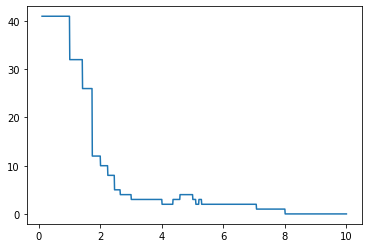

In [35]:
#seeing how clusters vary


x = np.linspace(.1,10,1000)
cluster_length = np.zeros(len(x))
m = 0 
for i in x:
    clustering = DBSCAN(eps=i,min_samples=5).fit(A)
    cluster = clustering.labels_
    cluster_length[m] = max(cluster)
    m = m + 1
print(x)
print(cluster_length)
plt.plot(x,cluster_length)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

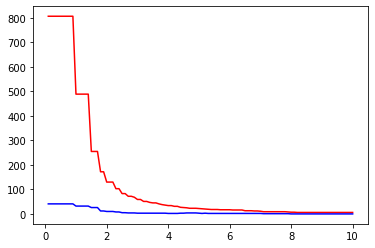

In [38]:
x = np.linspace(.1,10,100)
cluster_length1 = np.zeros(len(x))
m = 0 
for i in x:
    clustering = DBSCAN(eps=i,min_samples=1).fit(A)
    cluster = clustering.labels_
    cluster_length1[m] = max(cluster)
    m = m + 1
    
    
x = np.linspace(.1,10,100)
cluster_length2 = np.zeros(len(x))
m = 0 
for i in x:
    clustering = DBSCAN(eps=i,min_samples=5).fit(A)
    cluster = clustering.labels_
    cluster_length2[m] = max(cluster)
    m = m + 1

plt.plot(x,cluster_length1,'r')
plt.plot(x,cluster_length2,'b')
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

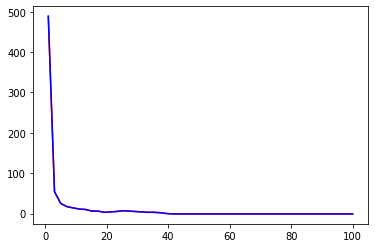

In [39]:
x = np.linspace(1,100)
cluster_length3 = np.zeros(len(x))
m = 0 
for i in x:
    clustering = DBSCAN(eps=1,min_samples=i).fit(A)
    cluster = clustering.labels_
    cluster_length3[m] = max(cluster)
    m = m + 1
    
    
x = np.linspace(1,100)
cluster_length4 = np.zeros(len(x))
m = 0 
for i in x:
    clustering = DBSCAN(eps=1,min_samples=i).fit(A)
    cluster = clustering.labels_
    cluster_length4[m] = max(cluster)
    m = m + 1

plt.plot(x,cluster_length3,'r')
plt.plot(x,cluster_length4,'b')
plt.show

In [40]:
from mpl_toolkits import mplot3d

In [63]:
x = np.linspace(1,10)
y = np.linspace(.1,10,10)
cluster_matrix = np.zeros([len(x),len(y)])
m = 0 
n = 0
for i in x:
    m = 0
    print(cluster_matrix)
    for j in y:
        clustering = DBSCAN(eps=j,min_samples=i).fit(A)
        cluster = clustering.labels_
        cluster_matrix[n][m] = max(cluster)
        m = m + 1
    n = n + 1

def f(x,y):
    clustering = DBSCAN(eps=y,min_samples=x).fit(A)
    cluster = clustering.labels_
    return max(cluster)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

[[807. 489. 103.  47.  26.  18.  13.   9.   6.   6.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [255. 163.  29.  17.  11.   7.   5.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [122.  87.  11.  10.   8.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 64.  54.  10.   6.   7.   5.   4.   2.   1.   1.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.   0.]
 [ 41.  32.   8.   3.   3.   2.   2.   1.   0.

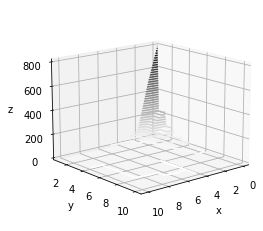

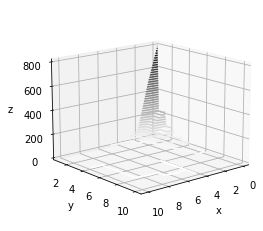

In [74]:

Y, X = np.meshgrid(y, x)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(Y, X, cluster_matrix, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.view_init(15,50 )
fig

In [1]:
from collections import defaultdict

In [3]:
dd = defaultdict(int) #inside parentheses put the type of value ie list int
for x in range(10):
    dd[x] = x**2

In [4]:
dd[7]

49

In [5]:
print(dd)

defaultdict(<class 'int'>, {0: 0, 1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81})


# THis is it title

## subtitle

#for getting to markdown esc then m then enter

energy balance
$ \frac{dm}{dt} = m_{in}(PE+ Hin + KE) + m_{out}(PE)$

In [ ]:
#superscript carrot